In [1]:
from jax_renderer_primitives import rasterize_fwd, rasterize_bwd

import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
from random import randint
from tqdm import tqdm
from time import time

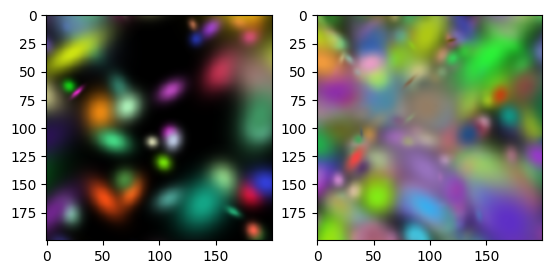

In [2]:
key = jax.random.PRNGKey(5)
N = 100
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

color_jax, res = rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    jnp.eye(4),
    200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
)
color_jax_gt = np.array(color_jax)

key = jax.random.PRNGKey(10)
N = 400
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

color_jax, res = rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    jnp.eye(4),
    200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
)

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax_gt, (1,2,0)))
ax2.imshow(jnp.transpose(color_jax, (1,2,0)))

0
0.0063476562
1
0.0025634766
2
0.00061035156
3
0.014160156
4
0.0008239746
0
2343.1748
1
0.0005493164
2
0.00018310547
3
0.013671875
4
0.0028076172
0
2707.4084
1
0.006713867
2
0.7053375
3
1.3007812
4
0.23934126
0
32199.01
1
0.008056641
2
151.75757
3
10293.067
4
1371.0007


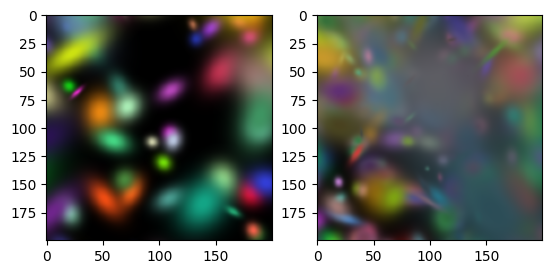

In [3]:
def f(loc_res, loc_gradients):
    (
        d,
        loc_grad_colors_precomp_jax,
        loc_grad_opacities_jax,
        loc_grad_means3D_jax,
        a,
        b,
        loc_grad_scales_jax,
        loc_grad_rotations_jax,
        c
    ) = rasterize_bwd(loc_res, loc_gradients)
    return (
        loc_grad_means3D_jax,
        loc_grad_colors_precomp_jax,
        loc_grad_opacities_jax,
        loc_grad_scales_jax,
        loc_grad_rotations_jax,
    )

for _ in range(4):
    color_jax, res = rasterize_fwd(
        means3D, colors_precomp, opacity, scales, rotations,
        jnp.eye(4),
        200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
    )

    gradients = jnp.array(color_jax - color_jax_gt)

    (
        d,
        grad_colors_precomp_jax2,
        grad_opacities_jax2,
        grad_means3D_jax2,
        a,
        b,
        grad_scales_jax2,
        grad_rotations_jax2,
        c
    ) = rasterize_bwd(res, gradients)

    (
        grad_means3D_jax,
        grad_colors_precomp_jax,
        grad_opacities_jax,
        grad_scales_jax,
        grad_rotations_jax,
    ) = f(res, gradients)

    a = [
        grad_means3D_jax,
        grad_colors_precomp_jax,
        grad_opacities_jax,
        grad_scales_jax,
        grad_rotations_jax,
    ]
    b =  [
        grad_means3D_jax2,
        grad_colors_precomp_jax2,
        grad_opacities_jax2,
        grad_scales_jax2,
        grad_rotations_jax2,
    ]
    for (idx,(i,j)) in enumerate(zip(a,b)):
        print(idx)
        print(jnp.abs(i-j).max())

    colors_precomp = colors_precomp - grad_colors_precomp_jax2  * 0.0004
    means3D = means3D - grad_means3D_jax2  * 0.00001
    scales = scales - grad_scales_jax2  * 0.00001
    rotations = rotations - grad_rotations_jax2  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax_gt, (1,2,0)))
ax2.imshow(jnp.transpose(color_jax, (1,2,0)))

In [5]:
jnp.savez("test.npz", *res)

: 

In [ ]:
for i, element in enumerate(res):
    if isinstance(element, jnp.ndarray):
        print(i, element.shape)
    else:
        print(i, element, type(element))

0 (400, 3)
1 (400, 3)
2 (400, 1)
3 (400, 3)
4 (400, 4)
5 200 <class 'int'>
6 200 <class 'int'>
7 300.0 <class 'float'>
8 300.0 <class 'float'>
9 100.0 <class 'float'>
10 100.0 <class 'float'>
11 0.01 <class 'float'>
12 2.5 <class 'float'>
13 (1,)
14 (3, 200, 200)
15 (400,)
16 (1000000,)
17 (1000000,)
18 (10000000,)
19 (4, 4)
20 (4, 4)


: 

In [20]:
a =f(res, gradients)
b = f(res, gradients)
for (idx,(i,j)) in enumerate(zip(a,b)):
    print(idx)
    assert jnp.allclose(i,j, rtol=1e-3)

0
1
2
3
4


In [22]:
jnp.abs(a[4] - b[4]).max()

Array(0.00247192, dtype=float32)

In [18]:
j

Array([[   0.       ,    0.       ,    0.       ],
       [   0.6939494,   -6.108794 ,    1.9711576],
       [   0.       ,    0.       ,    0.       ],
       ...,
       [   0.       ,    0.       ,    0.       ],
       [  -4.241171 , -118.77587  ,   37.451828 ],
       [  -2.934331 ,  -14.01893  ,    5.173593 ]], dtype=float32)

In [ ]:


    # (grad_means2D_jax,
    #             grad_colors_precomp_jax,
    #             grad_opacities_jax,
    #             grad_means3D_jax,
    #             grad_cov3Ds_precomp_jax,
    #             grad_sh_jax,
    #             grad_scales_jax, grad_rotations_jax, grad_conic) = rasterize_bwd(res, gradients)

    # assert jnp.allclose(grad_means3D_jax, grad_means3D_jax2, rtol=1e-3), f"jnp.abs(grad_means3D_jax - grad_means3D_jax2).max() = {jnp.abs(grad_means3D_jax - grad_means3D_jax2).max()}"
    # assert jnp.allclose(grad_colors_precomp_jax, grad_colors_precomp_jax2, rtol=1e-3)
    # assert jnp.allclose(grad_opacities_jax, grad_opacities_jax2, rtol=1e-3)
    # assert jnp.allclose(grad_scales_jax, grad_scales_jax2, rtol=1e-3)
    # assert jnp.allclose(grad_rotations_jax, grad_rotations_jax2, rtol=1e-3), f"jnp.abs(grad_rotations_jax - grad_rotations_jax2).max() = {jnp.abs(grad_rotations_jax - grad_rotations_jax2).max()}"

    # for i in (
    #     grad_means3D_jax,
    #     grad_colors_precomp_jax,
    #     grad_opacities_jax,
    #     grad_scales_jax,
    #     grad_rotations_jax,
    # ):
    #     print(i.shape)
    # print("1")

In [32]:
color_jax, res = rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    jnp.eye(4),
    200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
)

gradients = jnp.array(color_jax - color_jax_gt)

(grad_means2D_jax,
            grad_colors_precomp_jax,
            grad_opacities_jax,
            grad_means3D_jax,
            grad_cov3Ds_precomp_jax,
            grad_sh_jax,
            grad_scales_jax, grad_rotations_jax, grad_conic) = rasterize_bwd(res, gradients)


(
    grad_means3D_jax2,
    grad_colors_precomp_jax2,
    grad_opacities_jax2,
    grad_scales_jax2,
    grad_rotations_jax2,
) =rasterize_bwd2(res, gradients)

(
    grad_means3D_jax3,
    grad_colors_precomp_jax3,
    grad_opacities_jax3,
    grad_scales_jax3,
    grad_rotations_jax3,
) =rasterize_bwd2(res, gradients)

In [24]:
T = jnp.abs(grad_means3D_jax - grad_means3D_jax2).sum(1).argmax()
print(grad_means3D_jax[T])
print(grad_means3D_jax[T] - grad_means3D_jax2[T])

[-345.14868 -588.07196 -217.29382]
[-0.00027466 -0.00036621 -0.00016785]


In [30]:
jnp.abs(grad_rotations_jax - grad_rotations_jax3).max()

Array(2.8818846e-05, dtype=float32)

In [27]:
grad_colors_precomp_jax2

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-4.3407012e-02, -2.5839318e-04,  4.8468066e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.6814667e-05,  3.8717088e-05,  1.1411404e-04],
       [ 2.0373680e-03,  1.7208580e-03,  1.9256279e-03]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


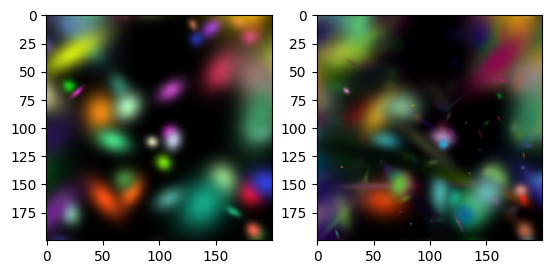

In [ ]:
for _ in range(100):
    color_jax, res = rasterize_fwd(
        means3D, colors_precomp, opacity, scales, rotations,
        jnp.eye(4),
        200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
    )
    (
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far,
        num_rendered_jax,
        color_jax,
        radii_jax,
        geomBuffer_jax,
        binningBuffer_jax,
        imgBuffer_jax,
        view_matrix,
        projmatrix
    ) = res
    fovX = jnp.arctan(image_width / 2 / fx) * 2.0
    fovY = jnp.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)
    grad_out_color_jax = jnp.array(color_jax - color_jax_gt)
    jax_bwd_args = (
        jnp.zeros(3),
        means3D, #1
        radii_jax, #2 
        colors_precomp, #3 
        scales, #4
        rotations, #5 
        # raster_settings.scale_modifier), 
        jnp.array([]), #6 
        view_matrix, #7 
        projmatrix, #8
        grad_out_color_jax, #9
        jnp.array([]), #10
        jnp.zeros(3), #11
        geomBuffer_jax, #12
        num_rendered_jax,
        binningBuffer_jax, #14
        imgBuffer_jax #15
    )

    (grad_means2D_jax,
    grad_colors_precomp_jax,
    grad_opacities_jax,
    grad_means3D_jax,
    grad_cov3Ds_precomp_jax,
    grad_sh_jax,
    grad_scales_jax, grad_rotations_jax, _) = rasterizer_bwd_primitive.bind(
                *jax_bwd_args,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                sh_degree=0
    )
    colors_precomp = colors_precomp - grad_colors_precomp_jax  * 0.0004
    means3D = means3D - grad_means3D_jax  * 0.00001
    scales = scales - grad_scales_jax  * 0.00001
    rotations = rotations - grad_rotations_jax  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax_gt, (1,2,0)))
ax2.imshow(jnp.transpose(color_jax, (1,2,0)))

In [14]:
grad_means3D_jax3[10]

Array([-0.30701703, -0.1812141 ,  0.10734708], dtype=float32)

In [5]:
print(jnp.abs(grad_means3D_jax2 - grad_means2D_jax).max())

583.9884


In [10]:
grad_means3D_jax

Array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


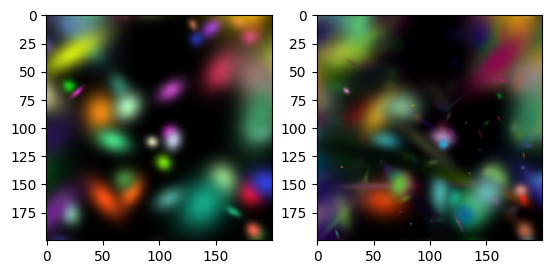

In [26]:
for _ in range(100):
    color_jax, res = rasterize_fwd(
        means3D, colors_precomp, opacity, scales, rotations,
        jnp.eye(4),
        200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
    )
    (
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far,
        num_rendered_jax,
        color_jax,
        radii_jax,
        geomBuffer_jax,
        binningBuffer_jax,
        imgBuffer_jax,
        view_matrix,
        projmatrix
    ) = res
    fovX = jnp.arctan(image_width / 2 / fx) * 2.0
    fovY = jnp.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)
    grad_out_color_jax = jnp.array(color_jax - color_jax_gt)
    jax_bwd_args = (
        jnp.zeros(3),
        means3D, #1
        radii_jax, #2 
        colors_precomp, #3 
        scales, #4
        rotations, #5 
        # raster_settings.scale_modifier), 
        jnp.array([]), #6 
        view_matrix, #7 
        projmatrix, #8
        grad_out_color_jax, #9
        jnp.array([]), #10
        jnp.zeros(3), #11
        geomBuffer_jax, #12
        num_rendered_jax,
        binningBuffer_jax, #14
        imgBuffer_jax #15
    )

    (grad_means2D_jax,
    grad_colors_precomp_jax,
    grad_opacities_jax,
    grad_means3D_jax,
    grad_cov3Ds_precomp_jax,
    grad_sh_jax,
    grad_scales_jax, grad_rotations_jax, _) = rasterizer_bwd_primitive.bind(
                *jax_bwd_args,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                sh_degree=0
    )
    colors_precomp = colors_precomp - grad_colors_precomp_jax  * 0.0004
    means3D = means3D - grad_means3D_jax  * 0.00001
    scales = scales - grad_scales_jax  * 0.00001
    rotations = rotations - grad_rotations_jax  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax_gt, (1,2,0)))
ax2.imshow(jnp.transpose(color_jax, (1,2,0)))

In [7]:
tan_fovx

0.7499999908297853

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


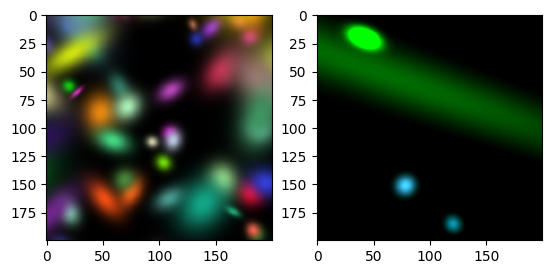

In [5]:
for _ in range(100):
    color_jax, res = rasterize_fwd(
        means3D, colors_precomp, opacity, scales, rotations,
        jnp.eye(4),
        200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
    )
    gradients = jnp.array(color_jax - color_jax_gt)
    (
    grad_means3D_jax,
    grad_colors_precomp_jax,
    grad_opacities_jax,
    grad_scales_jax,
    grad_rotations_jax) = rasterize_bwd(res, gradients)[:5]

    colors_precomp = colors_precomp - grad_colors_precomp_jax  * 0.0004
    means3D = means3D - grad_means3D_jax  * 0.00001
    # scales = scales - grad_scales_jax  * 0.00001
    rotations = rotations - grad_rotations_jax  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax_gt, (1,2,0)))
ax2.imshow(jnp.transpose(color_jax, (1,2,0)))

In [ ]:
key = jax.random.PRNGKey(10)
N = 600
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)


In [19]:
from jax_renderer_primitives import _build_rasterize_gaussians_fwd_primitive, _build_rasterize_gaussians_bwd_primitive
from functools import partial
from jax import custom_vjp
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import math

rasterizer_fwd_primitive = _build_rasterize_gaussians_fwd_primitive()
rasterizer_bwd_primitive = _build_rasterize_gaussians_bwd_primitive()


def rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    camera_pose,
    image_width, image_height, fx,fy, cx,cy,near,far
):
    fovX = jnp.arctan(image_width / 2 / fx) * 2.0
    fovY = jnp.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)

    proj_matrix = getProjectionMatrix(jnp.array([image_width, image_height, fx,fy, cx,cy,near,far]))
    view_matrix = jnp.transpose(jnp.linalg.inv(camera_pose))

    cov3D_precomp = jnp.zeros((N,3))
    sh = jnp.zeros((N,3))


    projmatrix = view_matrix @ proj_matrix
    (
        num_rendered_jax,
        color_jax,
        radii_jax,
        geomBuffer_jax,
        binningBuffer_jax,
        imgBuffer_jax
    ) = rasterizer_fwd_primitive.bind(
                jnp.zeros(3), # bg
                means3D,
                colors_precomp,
                opacity,
                scales,
                rotations,
                cov3D_precomp,
                view_matrix,
                projmatrix,
                sh,
                jnp.zeros(3), # campos
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                image_height=image_height, 
                image_width=image_width,  
                sh_degree=0
    )
    return (num_rendered_jax, color_jax)

key = jax.random.PRNGKey(5)
N = 100
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

num_rendered_jax, color_jax = rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    jnp.eye(4),
    200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
)
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color_jax, (1,2,0)))

TypeError: getProjectionMatrix() missing 3 required positional arguments: 'zfar', 'fovX', and 'fovY'

In [1]:
# import jax

def rasterize_bwd(
        _raster_settings_fcn,
        saved_tensors,
        grads_color_radii,   
):  
    grad_out_color, _ = grads_color_radii
    r = _raster_settings_fcn()

    bg, viewmatrix, projmatrix, campos, tanfovx, tanfovy, image_height, image_width, sh_degree = r.bg, r.viewmatrix, r.projmatrix, r.campos, r.tanfovx, r.tanfovy, r.image_height, r.image_width, r.sh_degree
    num_rendered, colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer = saved_tensors

    out = _rasterizer_bwd_prim.bind(
        bg,
        means3D,         
        radii, 
        colors_precomp, 
        scales,         
        rotations, 
        cov3Ds_precomp, 
        viewmatrix, 
        projmatrix,         
        grad_out_color,         
        sh, 
        sh_degree, 
        geomBuffer, 
        num_rendered,  
        binningBuffer, 
        imgBuffer, 
        tanfovx=tanfovx,
        tanfovy=tanfovy, 
        sh_degree=0 
    )
    grad_means2D, grad_colors_precomp, grad_opacities, grad_means3D, grad_cov3Ds_precomp, grad_sh, grad_scales, grad_rotations, _ = out

    return grad_means3D, grad_colors_precomp, grad_opacities, grad_scales, grad_rotations, grad_cov3Ds_precomp, grad_sh





NameError: name 'rasterize' is not defined